In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb # https://qiita.com/taki_tflare/items/dfa47e3f353baf96670b
import numpy as np
import pandas as pd
import seaborn as sns
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn import datasets, metrics, cross_validation
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as c_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12, 4

/Users/tatsuyahagiwara/anaconda3/envs/xgboost/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/tatsuyahagiwara/anaconda3/envs/xgboost/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
"""
train/testデータ作成

# dfの作成
f1=pd.read_csv('f1.csv')
f1=f1.fillna(0)

f2=pd.read_csv('f2.csv')
f2=f2.fillna(0)
f1['label']=0
f2['label']=1
df=pd.concat([f1, f2])
df.to_csv('df.csv')

"""
f1=pd.read_csv('df.csv')
f1=f1.drop('Unnamed: 0', axis=1)
f1.shape

(2488981, 11)

In [3]:
# ラベル
target=pd.DataFrame(f1['label'])
print(target.shape)

# 特徴量
data=f1.drop('label', axis=1)
print(data.shape)

(2488981, 1)
(2488981, 10)


In [4]:
# 標準化
f1_columns=list(data.columns)

sc = StandardScaler()
dff = sc.fit_transform(data)
dff=pd.DataFrame(dff)
dff.columns=f1_columns

sc = StandardScaler()
dff = sc.fit_transform(data)
dff=pd.DataFrame(dff)
dff.columns=f1_columns
dff.head()

,buyer_hasso_average,buyer_kaitsuke_seiko_average,rating_good,point,coupon,safety_tesuryo,popularity_boost,teikei_cd,minyuka_tag,login
0,-0.862838,0.623935,-0.135379,-0.049235,-0.092824,-0.121587,-0.034997,-0.157366,-0.243984,-0.248868
1,-0.363900,0.626828,-0.135379,-0.049235,-0.092824,-0.171315,-0.034997,-0.157366,-0.243984,-0.007324
2,0.220880,0.134420,-0.085517,-0.049235,-0.092824,-0.030418,-0.034997,-0.157366,-0.071123,-0.122345
3,-0.733057,0.081946,-0.031501,-0.049235,-0.092824,-0.067715,-0.034997,-0.157366,-0.243984,-0.260370
4,-1.148358,0.662511,-0.073052,-0.049235,-0.092824,-0.109155,-0.034997,-0.157366,-0.243984,-0.248868


In [48]:
# train/test データに分ける
train_x, test_x, train_y, test_y = train_test_split(data,
                                target, test_size=0.4,random_state=0)

In [32]:
"""
ハイパーパラメータ探索
"""

# デフォルト値のパラメーターで特徴量の重要度を可視化

def modelfit(alg, train_x, train_y, test_x, test_y,
             useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_x, label=train_y)
        xgtest = xgb.DMatrix(test_x)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train_x, train_y, eval_metric='auc')
    
        
    #Predict training set:
    train_predictions = alg.predict(train_x)
    dtrain_predprob = alg.predict_proba(train_x)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_y, dtrain_predprob.round()))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, dtrain_predprob))


    #  Predict on testing data:
    dtest_predprob = alg.predict_proba(test_x)[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(test_y, dtest_predprob.round()))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

/Users/tatsuyahagiwara/anaconda3/envs/xgboost/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tatsuyahagiwara/anaconda3/envs/xgboost/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tatsuyahagiwara/anaconda3/envs/xgboost/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.8741
AUC Score (Train): 0.909197
AUC Score (Test): 0.732088


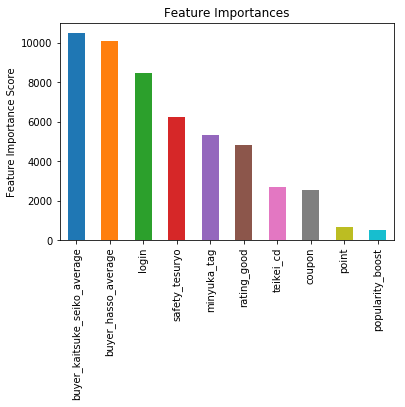

In [8]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train_x, train_y, test_x, test_y)

In [33]:
# データを行列に変換
train_x=np.reshape(np.array(train_x), (len(train_x),10))
test_x=np.reshape(np.array(test_x), (len(test_x),10))
train_y=np.reshape(np.array(train_y), (len(np.array(train_y)),))
test_y=np.reshape(np.array(test_y), (len(np.array(test_y)),))

In [13]:
"""
ハイパーパラメータ探索

# ハイパーパラメータ
'learning_rate', 'max_depth', 'colsample_bytree', 'subsample',
 'min_child_weight', 'reg_alpha', 'gamma'

# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
"""
params = {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],}
# モデルにインスタンス生成
mod = xgb.XGBRegressor()
# ハイパーパラメータ探索
cv = GridSearchCV(mod, params, cv = 10, scoring= 'roc_auc', n_jobs =-1)
cv.fit(train_x, train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [14]:
cv.grid_scores_, cv.best_params_, cv.best_score_

([mean: 0.87373, std: 0.00214, params: {'gamma': 0.0, 'reg_alpha': 1e-05},
  mean: 0.87373, std: 0.00214, params: {'gamma': 0.0, 'reg_alpha': 0.01},
  mean: 0.87376, std: 0.00211, params: {'gamma': 0.0, 'reg_alpha': 0.1},
  mean: 0.87358, std: 0.00201, params: {'gamma': 0.0, 'reg_alpha': 1},
  mean: 0.87191, std: 0.00209, params: {'gamma': 0.0, 'reg_alpha': 100},
  mean: 0.87373, std: 0.00214, params: {'gamma': 0.1, 'reg_alpha': 1e-05},
  mean: 0.87373, std: 0.00214, params: {'gamma': 0.1, 'reg_alpha': 0.01},
  mean: 0.87376, std: 0.00211, params: {'gamma': 0.1, 'reg_alpha': 0.1},
  mean: 0.87358, std: 0.00201, params: {'gamma': 0.1, 'reg_alpha': 1},
  mean: 0.87194, std: 0.00210, params: {'gamma': 0.1, 'reg_alpha': 100},
  mean: 0.87373, std: 0.00214, params: {'gamma': 0.2, 'reg_alpha': 1e-05},
  mean: 0.87373, std: 0.00214, params: {'gamma': 0.2, 'reg_alpha': 0.01},
  mean: 0.87376, std: 0.00211, params: {'gamma': 0.2, 'reg_alpha': 0.1},
  mean: 0.87358, std: 0.00201, params: {'gamma

In [35]:
"""
train/test/evvaluation
"""

def objective(params):

    skf = cross_validation.StratifiedKFold(
        train_y, # Samples to split in K folds
        n_folds=5, # Number of folds. Must be at least 2.
        shuffle=True, # Whether to shuffle each stratification of the data before splitting into batches.
        random_state=30 # pseudo-random number generator state used for shuffling
    )

    boost_rounds = []
    score = []

    for train, test in skf:
        _train_x, _test_x, _train_y, _test_y = \
            train_x[train], train_x[test], train_y[train], train_y[test]

        train_xd = xgb.DMatrix(_train_x, label=_train_y)
        test_xd = xgb.DMatrix(_test_x, label=_test_y)
        watchlist = [(train_xd, 'train'),(test_xd, 'eval')]

        model = xgb.train(
            params,
            train_xd,
            num_boost_round=100,
            evals=watchlist,
            early_stopping_rounds=30
        )

        boost_rounds.append(model.best_iteration)
        score.append(model.best_score)

    print('average of best iteration:', np.average(boost_rounds))
    return {'loss': np.average(score), 'status': STATUS_OK}

def optimize(trials):
    space = {'booster':'dart',
         'learning_rate':0.1,
         'n_estimators':1000,
         'sample_type':'uniform',
         'normalize_type': 'tree',
         'objective':'binary:logistic',
         'min_child_weight':1,
         'max_depth':9,
         'gamma':0.0,
         'subsample':0.6,
         'colsample_bytree':0.9,
         'reg_alpha':1e-05,
         'nthread':4,
         'scale_pos_weight':1,
         'seed':27,}
    
    # minimize the objective over the space
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=10
    )

    return best_params

In [ ]:
# parameter tuning
trials = Trials()
best_params = optimize(trials)
print(best_params)
"""
[18:01:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=9
[18:01:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[99]	train-error:0.128469	eval-error:0.132042
average of best iteration: 98.6
"""

In [ ]:
# 損失関数(loss)の計算
print(objective(best_params))
"""
[99]	train-rmse:0.303862	eval-rmse:0.306476
average of best iteration: 99.0
{'loss': 0.3063846, 'status': 'ok'}
"""

In [ ]:
# train　とbestパラメーターを求める
train_xd = xgb.DMatrix(train_x, label=train_y)
bst = xgb.train(best_params, train_xd, num_boost_round=100)
"""
[18:17:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 
126 extra nodes, 0 pruned nodes, max_depth=6
"""

In [50]:
# 予測とMSEで評価
pred_y = bst.predict(xgb.DMatrix(test_x))
mse = metrics.mean_squared_error(test_y, pred_y)
print(mse)

0.09363243227511146


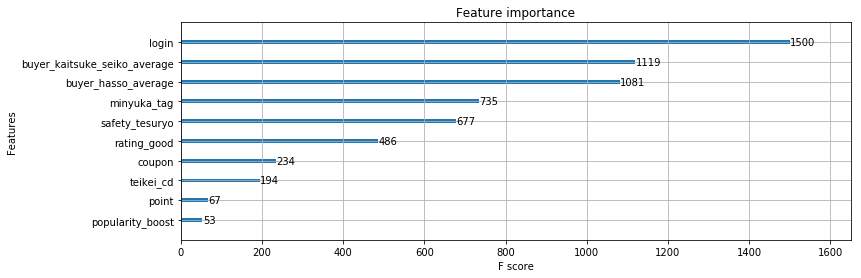

In [51]:
"""
ハイパーパラメータの可視化.etc
"""
# 訓練後、特徴量の重要度の可視化
imp=bst.get_fscore()
xgb.plot_importance(bst)

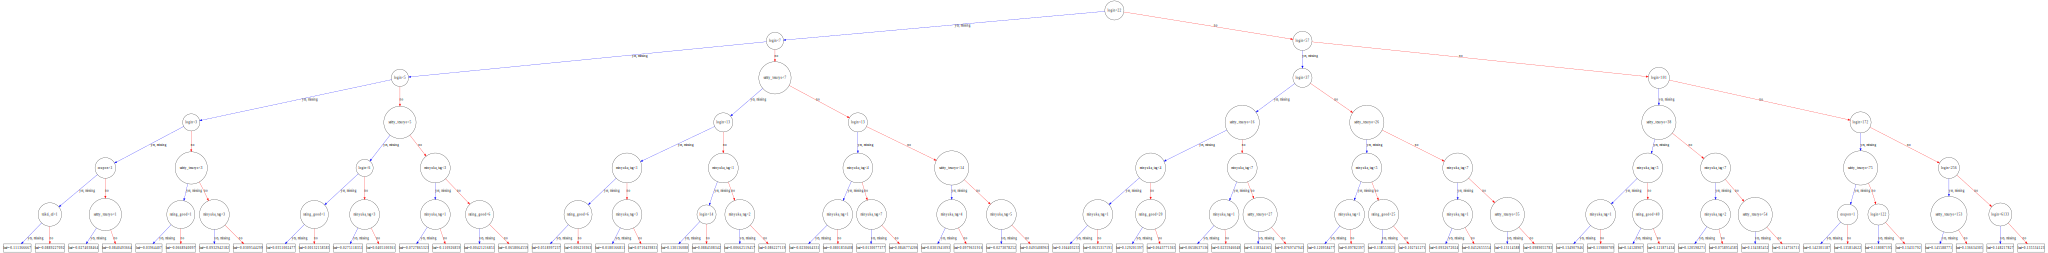

In [52]:
# 木の可視化と各枝のlabelの内訳
xgb.to_graphviz(bst)

In [53]:
# 木をpng fileで保存
graph=xgb.to_graphviz(bst)
graph.format='png'
graph.render('tree1')

'tree1.png'

AUC (accuracy) :0.8933666791898115


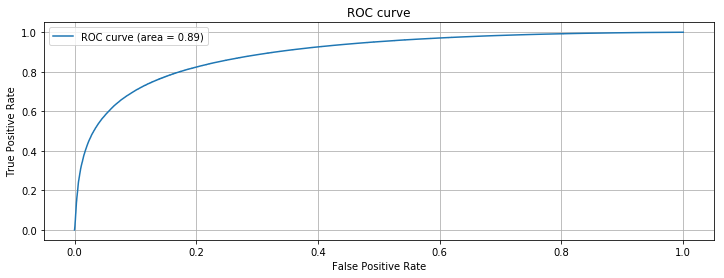

In [41]:
"""
AUCで評価
"""

# ROC曲線とAUCで評価 （正解率100%）
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y)

auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

print('AUC (accuracy) :{}'.format(roc_auc_score(test_y, pred_y)))

0.5483695283463061


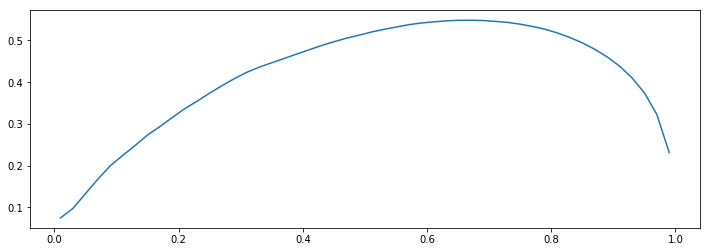

In [42]:
# 念のため、不均衡データに適してるMCCで評価（正解率100%）

from sklearn.metrics import matthews_corrcoef
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(test_y, pred_y>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [54]:
# モデルの保存
import joblib
#save model
joblib.dump(bst, 'hyp.model') 

# モデルのロード
#　xgb = joblib.load(filename)

['hyp.model']